# Imports

In [97]:
import imageio as imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import filters, restoration
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Podaj nazwę obrazu

In [98]:
image_name = '15_h'

# Wstępne przetwarzanie obrazu

Wczytanie obrazu

In [99]:
image_path = 'images/' + image_name + '.jpg'
image = cv2.imread(image_path)

Zamiana obrazu na skalę szarości

In [100]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Wykonanie rozmycia

In [101]:
blurred_image = cv2.blur(gray_image, (5, 5))

Wyostrzenie obrazu

In [102]:
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened_image = cv2.filter2D(blurred_image, -1, kernel)

Normalizacja histogramu kolorów

In [103]:
normalized_image = cv2.equalizeHist(sharpened_image)

Wyświetlenie obrazów

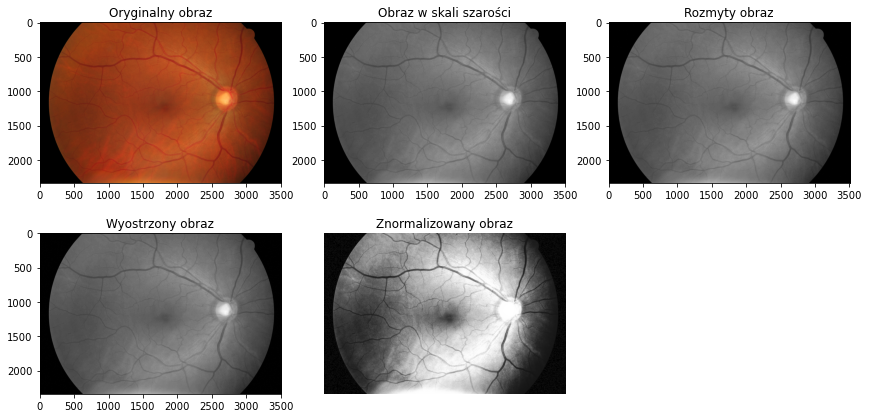

In [104]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Oryginalny obraz')
plt.subplot(2, 3, 2), plt.imshow(gray_image, cmap='gray'), plt.title('Obraz w skali szarości')
plt.subplot(2, 3, 3), plt.imshow(blurred_image, cmap='gray'), plt.title('Rozmyty obraz')
plt.subplot(2, 3, 4), plt.imshow(sharpened_image, cmap='gray'), plt.title('Wyostrzony obraz')
plt.subplot(2, 3, 5), plt.imshow(normalized_image, cmap='gray'), plt.title('Znormalizowany obraz')

plt.tight_layout()
plt.axis('off')
plt.show()

# Właściwe przetworzenie obrazu

Zastosowanie filtru Frangi'ego

In [105]:
vesselness_image = filters.frangi(normalized_image)

Wyświetlenie obrazów

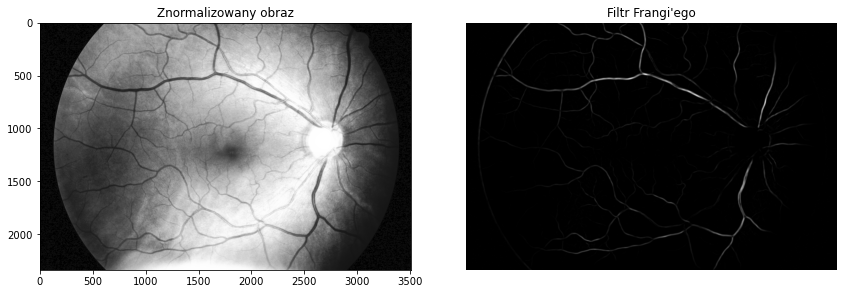

In [106]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.imshow(normalized_image, cmap='gray'), plt.title('Znormalizowany obraz')
plt.subplot(1, 2, 2), plt.imshow(vesselness_image, cmap='gray'), plt.title('Filtr Frangi\'ego')

plt.tight_layout()
plt.axis('off')
plt.show()

# Końcowe przetwarzanie obrazu

Usuwanie szumów

In [107]:
denoised_image = restoration.denoise_tv_chambolle(vesselness_image, weight=0.1)

Uzupełnienie luk

In [108]:
filled_image = restoration.inpaint_biharmonic(denoised_image, mask=(denoised_image == 0))

Przeskalowanie obrazu

In [109]:
resized_image = cv2.resize(filled_image, (512, 512))

Wyświetlenie wynikowego obrazu

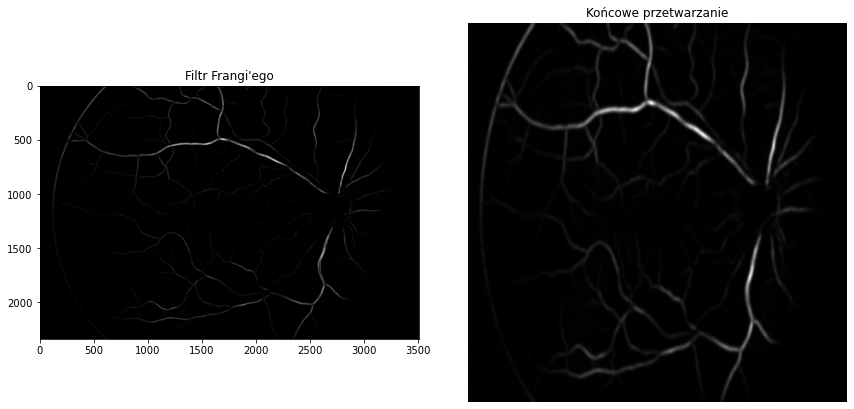

In [110]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.imshow(vesselness_image, cmap='gray'), plt.title('Filtr Frangi\'ego')
plt.subplot(1, 2, 2), plt.imshow(resized_image, cmap='gray'), plt.title('Końcowe przetwarzanie')

plt.tight_layout()
plt.axis('off')
plt.show()

# Wizualizacja wyniku

Wygenerowanie binarnej maski

In [111]:
mask = resized_image > 0.000001

Wykorzystanie binarnej maski do pokolorowania na biało pikseli zakwalifikowanych jako naczynia krwionośne

In [112]:
final_image = resized_image.copy()
final_image[mask] = 255

Wyświetlenie wynikowego obrazu

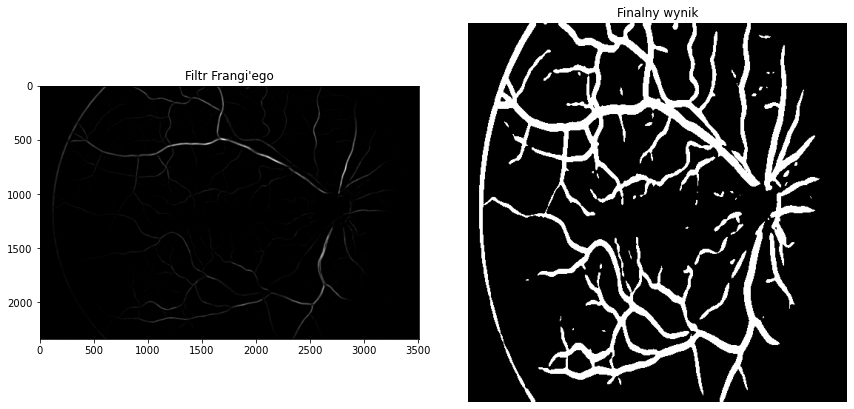

In [113]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.imshow(vesselness_image, cmap='gray'), plt.title('Filtr Frangi\'ego')
plt.subplot(1, 2, 2), plt.imshow(final_image, cmap='gray'), plt.title('Finalny wynik')

plt.tight_layout()
plt.axis('off')
plt.show()

In [114]:
new_path = 'analize/processed/' + image_name +'.jpg'

In [115]:
cv2.imwrite(new_path, final_image)

True

# Skuteczność algorytmu

Wczytanie pliku zawierąjacego obraz z ręcznie zaznaczonymi naczyniami

In [116]:
manual_image_path = 'manual1/' + image_name + '.tif'
manual_image = cv2.imread(manual_image_path)

Zamiana obrazu na skalę szarości

In [117]:
gray_manual_image = cv2.cvtColor(manual_image, cv2.COLOR_BGR2GRAY)

Wyświetlenie wynikowego i eksperckiego obrazu

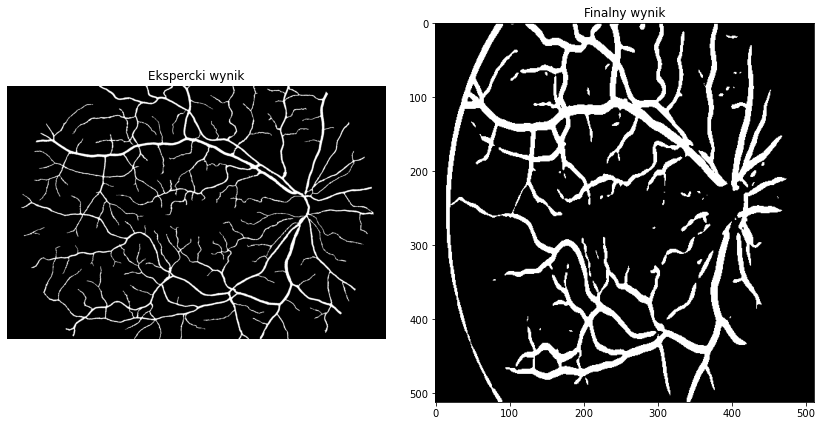

In [118]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2), plt.imshow(final_image, cmap='gray'), plt.title('Finalny wynik')
plt.subplot(1, 2, 1), plt.imshow(gray_manual_image, cmap='gray'), plt.title('Ekspercki wynik')

plt.tight_layout()
plt.axis('off')
plt.show()

Wygenerowanie binarnej, eksperckiej maski

In [119]:
correct_mask = gray_manual_image > 0

Przypisanie wymiarów maski do zmiennych

In [120]:
mask_height, mask_width = mask.shape

Obliczenie macierzy pomyłek

In [121]:
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0

for i in range(mask_height):
    for j in range(mask_width):
        if mask[i][j] == True and correct_mask[i][j] == True:
            true_positive += 1
        elif mask[i][j] == True and correct_mask[i][j] == False:
            false_positive += 1
        elif mask[i][j] == False and correct_mask[i][j] == True:
            false_negative += 1
        elif mask[i][j] == False and correct_mask[i][j] == False:
            true_negative += 1

Wyświetlenie macierzy pomyłek

In [122]:
print(true_positive, false_negative, false_positive, true_negative)

469 6078 39971 215626


Wizualizacja macierzy pomyłek

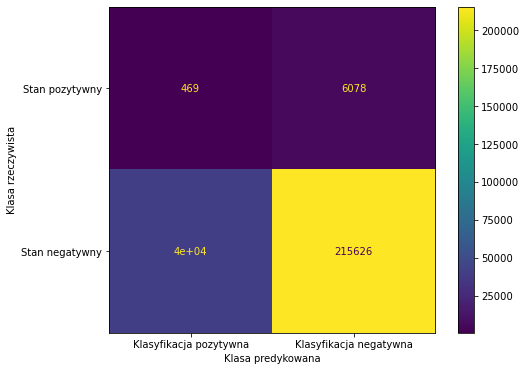

In [123]:
cm = np.array([[true_positive, false_negative], [false_positive, true_negative]])

# Tworzenie obiektu ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Definiowanie nowych etykiet dla osi
x_labels = ['Klasyfikacja pozytywna', 'Klasyfikacja negatywna']
y_labels = ['Stan pozytywny', 'Stan negatywny']

# Wyświetlanie wizualizacji macierzy pomyłek
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Modyfikowanie etykiet na osiach
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

# Modyfikowanie nagłówków dla osi x i y
ax.set_xlabel("Klasa predykowana")
ax.set_ylabel("Klasa rzeczywista")

# Wyświetlanie wizualizacji
plt.show()

Trafność

In [124]:
accuracy = (true_positive + true_negative)/(true_positive + false_positive + false_negative + true_negative)
accuracy

0.8243370056152344

Czułość

In [125]:
sensitivity = (true_positive)/(true_positive + false_negative)
sensitivity

0.07163586375439132

Swoistość

In [126]:
specificity = (true_negative)/(false_positive + true_negative)
specificity

0.8436171003572029

Średnia arytmetyczna czułości i swoistości

In [127]:
(sensitivity + specificity)/2

0.45762648205579715